In [15]:
# importing libraries and initial configs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sys
import pickle
import os
os.chdir("/add/your/path/here/")

pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [16]:
df = pd.read_pickle(".data/Imported_ML_Data_Cleaned.pkl")

In [17]:
# Pre-processing for the numerical attributes
# 1. Remove the outliers based on 3 standard deviations away from mean

for col in df.select_dtypes(include=np.number).columns.tolist():
    
    a = np.mean(df[col])
    b = np.std(df[col])

    df[col] = np.where(
        df[col] > a + 3 * b,
        a + 3 * b,
        np.where(df[col] < a - 3 * b, a - 3 * b, df[col]),
    )


In [18]:
# 2. Taking the log of the numerical attributes
num_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    df["log_" + col] = np.log(df[col])
    df["log_" + col] = df["log_" + col].replace(
        -np.inf, np.mean(df["log_" + col]) - 3 * np.std(df["log_" + col])
    )
    df["log_" + col] = df["log_" + col].replace(
        np.nan, np.mean(df["log_" + col]) + 3 * np.std(df["log_" + col])
    )



Checking for column: Census_ProcessorCoreCount


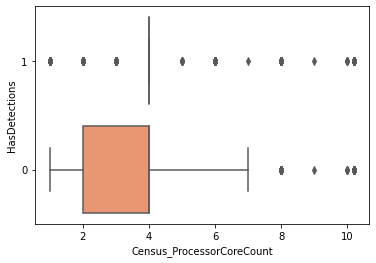

Checking for column: Census_PrimaryDiskTotalCapacity


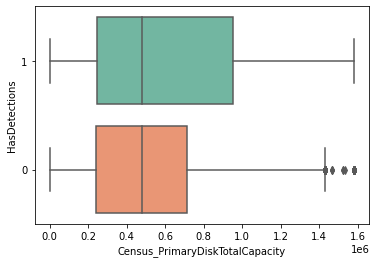

Checking for column: Census_SystemVolumeTotalCapacity


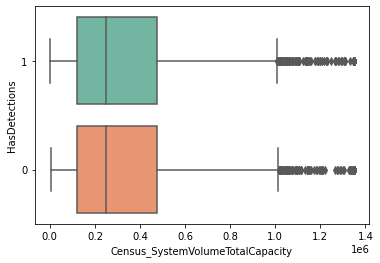

Checking for column: Census_TotalPhysicalRAM


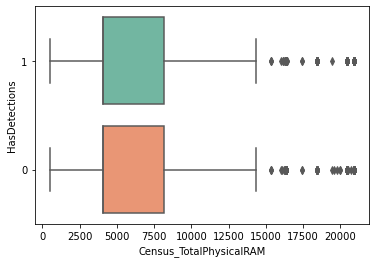

Checking for column: Census_InternalPrimaryDiagonalDisplaySizeInInches


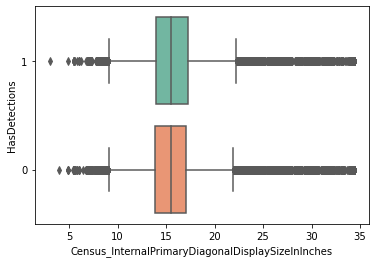

Checking for column: Census_InternalPrimaryDisplayResolutionHorizontal


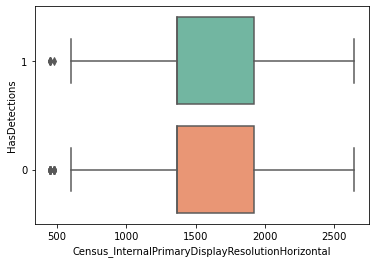

Checking for column: Census_InternalPrimaryDisplayResolutionVertical


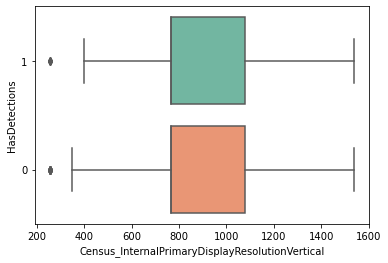

Checking for column: log_Census_ProcessorCoreCount


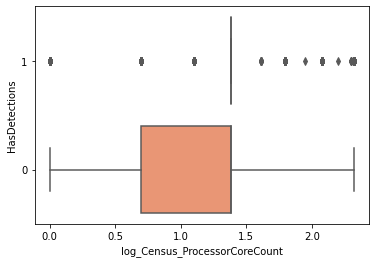

Checking for column: log_Census_PrimaryDiskTotalCapacity


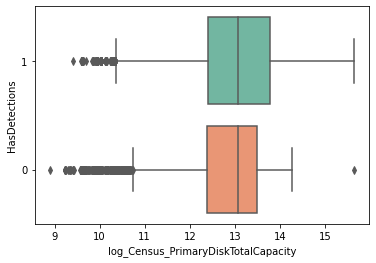

Checking for column: log_Census_SystemVolumeTotalCapacity


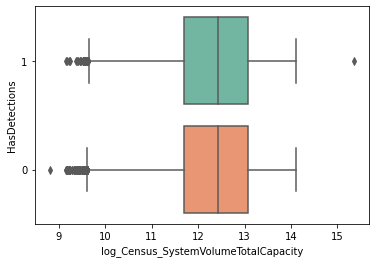

Checking for column: log_Census_TotalPhysicalRAM


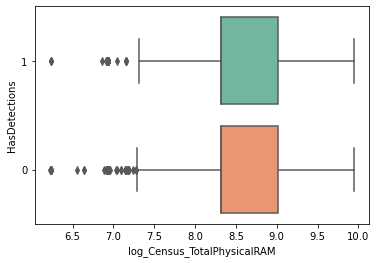

Checking for column: log_Census_InternalPrimaryDiagonalDisplaySizeInInches


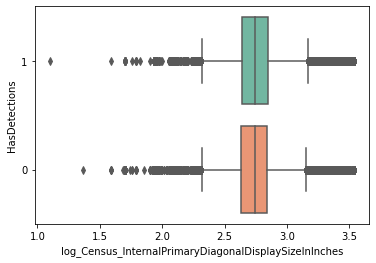

Checking for column: log_Census_InternalPrimaryDisplayResolutionHorizontal


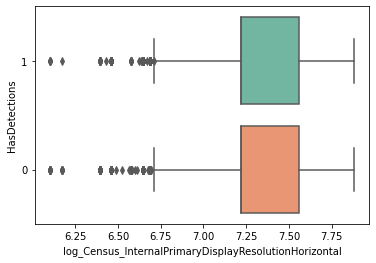

Checking for column: log_Census_InternalPrimaryDisplayResolutionVertical


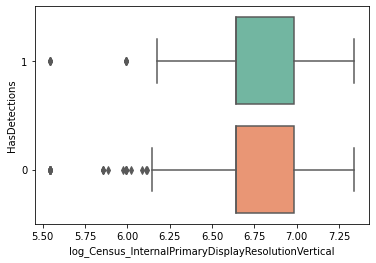

In [60]:
# Checking boxplots for numerical attributes
for col in df.select_dtypes(include=np.number).columns.tolist():
    print("Checking for column: {}".format(col))
    sns.boxplot(x=col, y="HasDetections", data=df, palette="Set2")
    plt.xlabel(col)
    plt.ylabel("HasDetections")
    plt.show();
    

In [19]:
convert_to_num = ["AVProductsInstalled","AVProductsEnabled"]

for col in convert_to_num:
    df[col] = df[col].astype(float).astype(int)

In [20]:
correlation_check= ['AVProductsInstalled',
'AVProductsEnabled',
'log_Census_ProcessorCoreCount',
 'log_Census_PrimaryDiskTotalCapacity',
 'log_Census_SystemVolumeTotalCapacity',
 'log_Census_TotalPhysicalRAM',
 'log_Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'log_Census_InternalPrimaryDisplayResolutionHorizontal',
 'log_Census_InternalPrimaryDisplayResolutionVertical']

<AxesSubplot:>

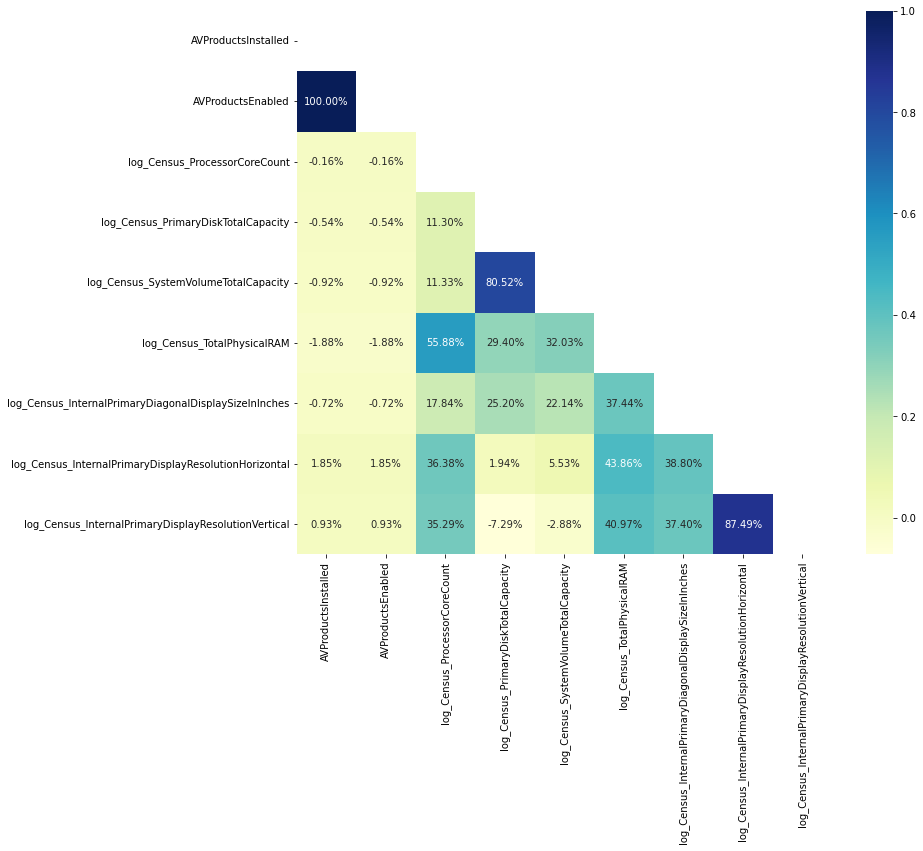

In [21]:
fig = plt.figure(figsize=(12, 10))

corr = df[correlation_check].corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    mask=np.triu(corr),
)


In [22]:
# Features to drop post correlation checks
corr_cols_drop = [
    "log_Census_PrimaryDiskTotalCapacity",
    "log_Census_InternalPrimaryDisplayResolutionVertical",
    "Census_ProcessorCoreCount",
    "Census_PrimaryDiskTotalCapacity",
    "Census_SystemVolumeTotalCapacity",
    "Census_TotalPhysicalRAM",
    "Census_InternalPrimaryDiagonalDisplaySizeInInches",
    "Census_InternalPrimaryDisplayResolutionHorizontal",
    "Census_InternalPrimaryDisplayResolutionVertical",
    "AVProductsInstalled"
]
df.drop(columns = corr_cols_drop, inplace = True)

In [23]:
# Categorical columns similar to other columns
# redundant information. Hence dropped.
cats_to_drop = [
    "MachineIdentifier",
    "OsBuildLab",
    "CityIdentifier",
    "GeoNameIdentifier",
    "LocaleEnglishNameIdentifier",
    "Census_ChassisTypeName",
    "Census_OSVersion",
    "Census_OSBranch",
    "Census_OSBuildNumber",
    "Census_OSSkuName",
    "Wdft_RegionIdentifier"
]

df.drop(columns= cats_to_drop, inplace=True)

In [24]:
# NA means that firewall was not there 
# hence replaced by zero
df["Firewall"].replace('-999999999.0','0.0', inplace=True)

In [25]:
class FrequencyEncoding():
    '''Class will keep the most common occuring features
    based on the limit given.'''
    def __init__(self, limit):
        self.limit = limit
        self.dict = {}

    def fit(self, data_frame):
        for i in list(data_frame.select_dtypes(include='object').columns):
            if len(data_frame[i].unique()) <= 2:
                pass
            else:
                bool_ = data_frame[i].value_counts(ascending=False)>self.limit
                vals = data_frame[i].value_counts(ascending=False)[bool_]
                self.dict[i] = list(vals.index)
        
    def transform(self, data_frame):
        data_frame1 = data_frame.copy()
        for j in self.dict:
            for k in self.dict[j]:
                data_frame1[j+k] = np.where(data_frame1[j] == k, 1,0)
        data_frame1.drop(columns=list(self.dict.keys()), inplace=True)

        return data_frame1

In [26]:
# We set limit to 2000 and than select features.
freq_en = FrequencyEncoding(2_000)
freq_en.fit(df)
freq_encoded_data = freq_en.transform(df)
# with 2000 limit we get 721 features total

In [27]:
# seperate X and ys
y = freq_encoded_data["HasDetections"]
x = freq_encoded_data.drop(columns="HasDetections")

In [32]:
# fit a random forest to the whole dataset
# select features, rank them in importance 
# and put them in a list 
rf_main = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_main.fit(x, y)
feature_imp = dict(zip(x.columns, rf_main.feature_importances_))
feat_imp = {
    k: v for k, v in sorted(feature_imp.items(), key=lambda item: item[1], reverse=True)
}
rf_features = list(feat_imp.keys())


In [125]:
# cross validation on feature selection
features_num = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 720]
aucs = []
for i in features_num:
    x_feat = x[rf_features[:i]].copy()
    X_train, X_test, y_train, y_test = train_test_split(x_feat, y, random_state=42)
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_test)[:, -1]
    auc = roc_auc_score(y_test, y_pred)
    aucs.append(auc)


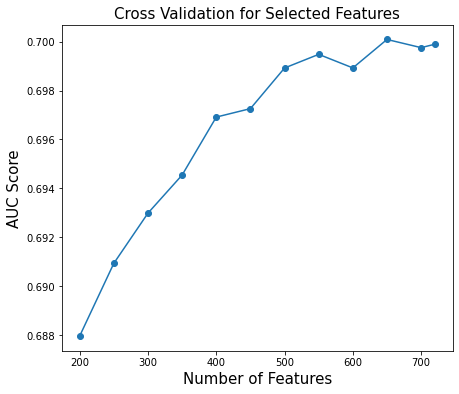

In [133]:
plt.figure(figsize=(7,6))
plt.plot(features_num, aucs, marker ='o')
plt.xlabel("Number of Features", fontsize=15)
plt.ylabel("AUC Score", fontsize=15)
plt.title("Cross Validation for Selected Features", fontsize=15)
plt.show()

In [135]:
freq_encoded_data.to_pickle('feature_engineered_df1.pkl')

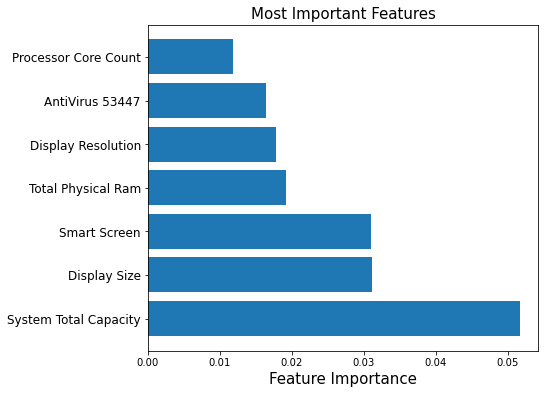

In [152]:
rf_features_imp = list(feat_imp.values())
features_best = [
    "System Total Capacity",
    "Display Size",
    "Smart Screen",
    "Total Physical Ram",
    "Display Resolution",
    "AntiVirus 53447",
    "Processor Core Count",
]
plt.figure(figsize=(7, 6))
plt.barh(features_best, rf_features_imp[:7])
plt.title("Most Important Features", fontsize=15)
plt.xlabel("Feature Importance", fontsize=15)
plt.yticks(fontsize=12)
plt.show()

In [37]:
#saving model and features
# import pickle
# with open('feature_select_model.pkl', "wb") as f:
#     pickle.dump(rf_main, f)

with open('imp_features.pkl', "wb") as f:
    pickle.dump(feat_imp, f)

In [29]:
# import pickle
# rf_main = pickle.load(open('feature_select_model.pkl', 'rb'))